# GPU-accelerated FBP with ASTRA

In [1]:
# IMPORTS
import gc
from fbp_fns import *
import sys
sys.path.append('../')

In [2]:
# # GARBAGE COLLECTION
if 'im' in globals():
    del im
if 'reconstruction_fbp' in globals():
    del reconstruction_fbp
gc.collect()

0

In [3]:
def average_stack(imgs, im_per_pos=5, show=False):
    # adapted from: https://stackoverflow.com/a/69721142
    image_sets = imgs.reshape((len(imgs)//im_per_pos, im_per_pos, imgs.shape[1], imgs.shape[2]))
    avg_stack = np.mean(image_sets, axis=1)
    if show:
        plt.imshow(avg_stack[0], cmap="gray")
        plt.title(f'Image 1 of {len(avg_stack)}')
        plt.show()
    print(f"Averaged original stack of {len(imgs)} down to {len(avg_stack)}.")
    return avg_stack

In [4]:
# SINGLE IMAGE

PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-03-17\embryo\2023-03-17 embryo transmission fd 175ms\MMStack_Pos0.ome.tif'
output_dir = '2023-03-17 embryo transmission no_rescale'
# bead_row = 1216

im = io.imread(PATH_TO_IMAGE)

background = io.imread(r'D:\MSci_Project\1_Data\2023-03-17\embryo\2023-03-17 background transmission fd 175ms\MMStack_Pos0.ome.tif')
background = average_stack(background)
background = background.astype('float64')
im = im.astype('float64')
im -= background

print(f'Loaded {im.shape[0]} projections, dimensions ({im.shape[1:]})')

# aligned = align(im, bead_row)
recon = reconstruct(im, output_dir, rescale=False)

Averaged original stack of 5 down to 1.
Loaded 400 projections, dimensions ((1392, 1040))


Reconstructing slices: 100%|█████████████████████████████████████████████| 1392/1392 [01:06<00:00, 20.87it/s]


Reconstructed, min=-700.1991577148438, max=786.334228515625. Saved to 2023-03-17 embryo transmission no_rescale.


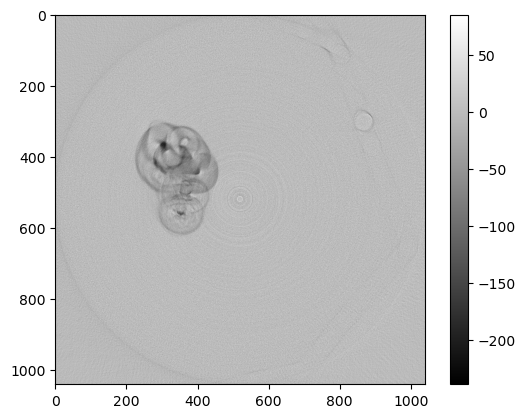

In [8]:
plt.imshow(recon[800], cmap='gray')
plt.colorbar()
plt.show()

In [6]:
# # FOCAL SCAN

# PATHS_TO_IMAGES = [r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd infocus\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -750um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -1500um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -2250um\MMStack_Pos0.ome.tif']
# output_dir = '2023-03-01 focal scan'
# bead_row = 626

# im = io.imread(PATHS_TO_IMAGES[0]) // len(PATHS_TO_IMAGES)
# for path in PATHS_TO_IMAGES[1:]:
#     im += io.imread(path) // len(PATHS_TO_IMAGES)
# print(f'Loaded {im.shape[0]} projections, dimensions ({im.shape[1:]})')
# aligned = align(im, bead_row)
# recon = reconstruct(aligned, output_dir)

In [7]:
# # MULTIPLE IMAGES

# PATHS_TO_IMAGES = [r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd infocus\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -750um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -1500um\MMStack_Pos0.ome.tif',
#                   r'D:\MSci_Project\1_Data\2023-03-01\focal scan\2023-03-01 fd -2250um\MMStack_Pos0.ome.tif']
# output_dirs = ['2023-03-01 infocus', '2023-03-01 -750um', '2023-03-01 -1500um', '2023-03-01 -2250um']
# bead_row = 626

# for PATH_TO_IMAGE, output_dir in zip(PATHS_TO_IMAGES, output_dirs):
#     im = io.imread(PATH_TO_IMAGE)
#     print(f'Loaded {im.shape[0]} projections, dimensions ({im.shape[1:]})')
#     aligned = align(im, bead_row)
#     recon = reconstruct(aligned, output_dir)
#     if 'im' in globals():
#         del im
#     if 'reconstruction_fbp' in globals():
#         del reconstruction_fbp
#     _ = gc.collect()